In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/topic-news/merged_April_May_DATE_THEMES_URL.csv
/kaggle/input/topic-news/June/20250606.gkg.csv
/kaggle/input/topic-news/June/20250608.gkg.csv
/kaggle/input/topic-news/June/20250601.gkg.csv
/kaggle/input/topic-news/June/20250605.gkg.csv
/kaggle/input/topic-news/June/20250609.gkg.csv
/kaggle/input/topic-news/June/20250602.gkg.csv
/kaggle/input/topic-news/June/20250604.gkg.csv
/kaggle/input/topic-news/June/20250603.gkg.csv
/kaggle/input/topic-news/June/20250610.gkg.csv
/kaggle/input/topic-news/June/20250607.gkg.csv
/kaggle/input/topic-news/May/20250531.gkg.csv
/kaggle/input/topic-news/May/20250505.gkg.csv
/kaggle/input/topic-news/May/20250524.gkg.csv
/kaggle/input/topic-news/May/20250515.gkg.csv
/kaggle/input/topic-news/May/20250519.gkg.csv
/kaggle/input/topic-news/May/20250503.gkg.csv
/kaggle/input/topic-news/May/20250429.gkg.csv
/kaggle/input/topic-news/May/20250516.gkg.csv
/kaggle/input/topic-news/May/20250529.gkg.csv
/kaggle/input/topic-news/May/20250528.gkg.csv
/kaggle/

In [ ]:
import pandas as pd
import os
from glob import glob
from collections import Counter
from tqdm import tqdm

# Hàm trích xuất chủ đề từ từng file
def extract_theme_counts(file_path):
    try:
        df = pd.read_csv(file_path, sep='\t', header=None, quoting=3, low_memory=False)
        if df.shape[1] < 4:
            return None
        theme_series = df[3].dropna()
        all_themes = []
        for row in theme_series:
            all_themes.extend(row.split(';'))
        theme_counts = Counter(all_themes)
        date_str = os.path.basename(file_path).split(".")[0]
        theme_counts['DATE'] = pd.to_datetime(date_str, format="%Y%m%d")
        return pd.DataFrame([theme_counts])
    except Exception as e:
        print(f"Lỗi ở file {file_path}: {e}")
        return None

# Các thư mục chứa dữ liệu của 3 tháng
folders = [
    "/kaggle/input/topic-news/April/",
    "/kaggle/input/topic-news/May/",
    "/kaggle/input/topic-news/June/"
]

# Gom tất cả các file
file_paths = []
for folder in folders:
    file_paths.extend(sorted(glob(os.path.join(folder, "*.csv"))))

# Xử lý từng file
all_data = []
for path in tqdm(file_paths):
    result = extract_theme_counts(path)
    if result is not None:
        all_data.append(result)

# Gộp tất cả dữ liệu lại
full_df = pd.concat(all_data, ignore_index=True).fillna(0)
full_df['DATE'] = pd.to_datetime(full_df['DATE'])
full_df = full_df.sort_values('DATE').set_index('DATE')

# Chọn top 20 chủ đề phổ biến
top_n = 20
top_themes = full_df.sum().sort_values(ascending=False).head(top_n).index.tolist()
if 'DATE' in top_themes:
    top_themes.remove('DATE')
full_df = full_df[top_themes]

# Xuất ra file CSV
output_path = "socialtrend_all.csv"
full_df.reset_index().to_csv(output_path, index=False)

print(f"✅ Đã lưu dữ liệu vào: {output_path}")
print("📊 Kích thước dữ liệu cuối cùng:", full_df.shape)
print(full_df.head())


 15%|█▌        | 11/72 [00:59<05:39,  5.56s/it]

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(full_df.values)
scaled_df = pd.DataFrame(scaled_data, columns=full_df.columns, index=full_df.index)


In [92]:
# Dùng từ đầu đến giữa tháng 5 để train, phần còn lại để test
train_data = scaled_df[scaled_df.index < '2025-05-20'].values
test_data = scaled_df[scaled_df.index >= '2025-05-20'].values

# Tăng độ dài chuỗi
seq_len = 10
pred_len = 7

In [94]:
print("Số ngày test:", len(test_data))
print("Số mẫu test khả dụng:", len(test_data) - seq_len - pred_len + 1)


Số ngày test: 22
Số mẫu test khả dụng: 6


In [95]:
import torch
from torch.utils.data import Dataset, DataLoader

class SocialTrendDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len]
        return x, y

train_dataset = SocialTrendDataset(train_data, seq_len, pred_len)
test_dataset = SocialTrendDataset(test_data, seq_len, pred_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [96]:
import torch.nn as nn

class DLinear(nn.Module):
    def __init__(self, seq_len, pred_len, input_dim):
        super().__init__()
        self.linear = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        x = x.permute(0, 2, 1)           # [batch, input_dim, seq_len]
        out = self.linear(x)             # [batch, input_dim, pred_len]
        out = out.permute(0, 2, 1)       # [batch, pred_len, input_dim]
        return out


In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DLinear(seq_len=seq_len, pred_len=pred_len, input_dim=scaled_df.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 | Loss: 0.5052
Epoch 2 | Loss: 0.6237
Epoch 3 | Loss: 0.4836
Epoch 4 | Loss: 0.5035
Epoch 5 | Loss: 0.4178
Epoch 6 | Loss: 0.4769
Epoch 7 | Loss: 0.5261
Epoch 8 | Loss: 0.4343
Epoch 9 | Loss: 0.4505
Epoch 10 | Loss: 0.3588
Epoch 11 | Loss: 0.4641
Epoch 12 | Loss: 0.3178
Epoch 13 | Loss: 0.3078
Epoch 14 | Loss: 0.3227
Epoch 15 | Loss: 0.3147
Epoch 16 | Loss: 0.3058
Epoch 17 | Loss: 0.3005
Epoch 18 | Loss: 0.2527
Epoch 19 | Loss: 0.3555
Epoch 20 | Loss: 0.2379
Epoch 21 | Loss: 0.2231
Epoch 22 | Loss: 0.2802
Epoch 23 | Loss: 0.2276
Epoch 24 | Loss: 0.2432
Epoch 25 | Loss: 0.1916
Epoch 26 | Loss: 0.1563
Epoch 27 | Loss: 0.2140
Epoch 28 | Loss: 0.2194
Epoch 29 | Loss: 0.1591
Epoch 30 | Loss: 0.1929
Epoch 31 | Loss: 0.1836
Epoch 32 | Loss: 0.1842
Epoch 33 | Loss: 0.1410
Epoch 34 | Loss: 0.1351
Epoch 35 | Loss: 0.1424
Epoch 36 | Loss: 0.1465
Epoch 37 | Loss: 0.1357
Epoch 38 | Loss: 0.1801
Epoch 39 | Loss: 0.1247
Epoch 40 | Loss: 0.1222
Epoch 41 | Loss: 0.1602
Epoch 42 | Loss: 0.0826
E

In [100]:
model.eval()
with torch.no_grad():
    total_loss = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)
        total_loss += loss.item()
    print(f"🧪 Test Loss: {total_loss/len(test_loader):.4f}")


🧪 Test Loss: 0.0951


In [101]:
# Flatten toàn bộ dự báo thành 1D
y_true_flat = y_true.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = mean_squared_error(y_true_flat, y_pred_flat, squared=False)

print(f"📊 MAE: {mae:.4f}")
print(f"📉 RMSE: {rmse:.4f}")


📊 MAE: 0.6125
📉 RMSE: 0.6797


In [102]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        y_true.append(y.cpu().numpy())
        y_pred.append(output.cpu().numpy())

y_true = np.concatenate(y_true, axis=0)  # [batch, pred_len, input_dim]
y_pred = np.concatenate(y_pred, axis=0)


In [103]:
input_dim = y_true.shape[-1]
y_true_seq = y_true.reshape(-1, input_dim)  # [samples * pred_len, input_dim]
y_pred_seq = y_pred.reshape(-1, input_dim)


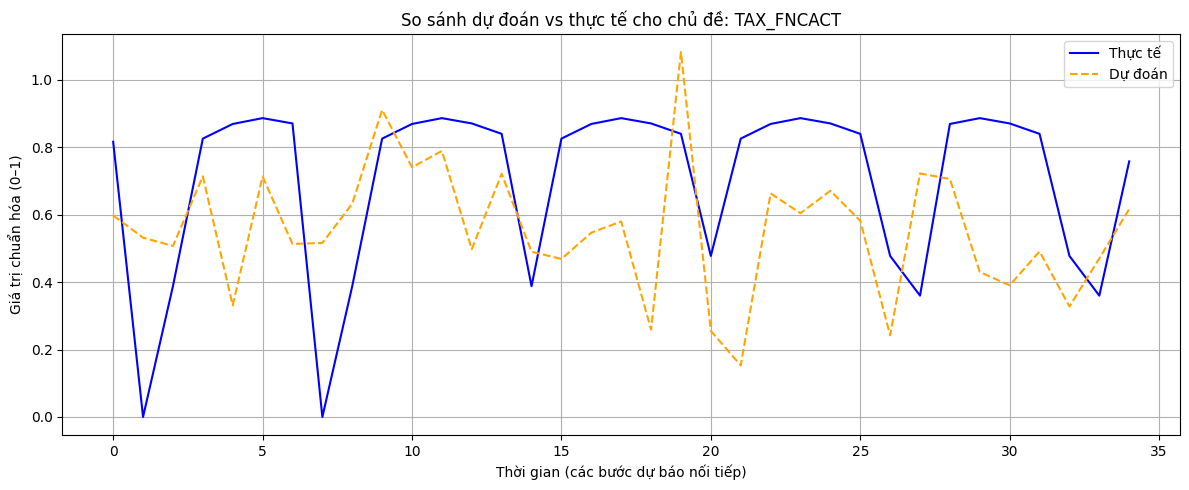

In [104]:
import matplotlib.pyplot as plt

# Chọn chủ đề đầu tiên (bạn có thể thay đổi index)
theme_idx = 0
theme_name = scaled_df.columns[theme_idx]

plt.figure(figsize=(12, 5))
plt.plot(y_true_seq[:, theme_idx], label="Thực tế", color="blue")
plt.plot(y_pred_seq[:, theme_idx], label="Dự đoán", color="orange", linestyle="--")
plt.title("So sánh dự đoán vs thực tế cho chủ đề: TAX_FNCACT")
plt.xlabel("Thời gian (các bước dự báo nối tiếp)")
plt.ylabel("Giá trị chuẩn hóa (0–1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


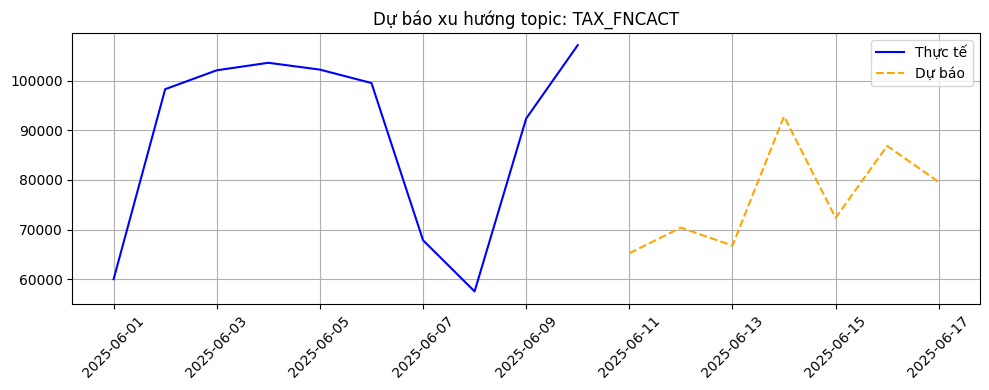

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# recent_seq: [seq_len, input_dim], pred_np: [pred_len, input_dim]
# Ghép để inverse_transform đúng shape
combined = np.vstack([recent_seq, pred_np])  # shape: [seq_len + pred_len, input_dim]

# Đảo ngược chuẩn hóa toàn bộ
inversed = scaler.inverse_transform(combined)

# Tách phần thực tế và dự báo
past_values_real = inversed[:seq_len]
pred_values_real = inversed[seq_len:]

# Dùng chỉ số chủ đề
topic_idx = 0  # thay đổi nếu muốn chủ đề khác
topic_name = scaled_df.columns[topic_idx]

# Tạo trục thời gian
past_dates = scaled_df.index[-seq_len:]
future_dates = pd.date_range(past_dates[-1] + pd.Timedelta(days=1), periods=pred_len)

# Vẽ biểu đồ
plt.figure(figsize=(10, 4))
plt.plot(past_dates, past_values_real[:, topic_idx], label='Thực tế', color='blue')
plt.plot(future_dates, pred_values_real[:, topic_idx], label='Dự báo', linestyle='--', color='orange')
plt.title(f"Dự báo xu hướng topic: {topic_name}")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
